<a href="https://colab.research.google.com/github/ArmandoSep/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/LS_DS_222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

Today's lesson has two take-away messages:

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.


### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- **category_encoders** 
- **graphviz**
- ipywidgets
- matplotlib
- numpy
- pandas
- seaborn
- scikit-learn

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Use scikit-learn for random forests

## Overview

Let's fit a Random Forest!

![](https://pbs.twimg.com/media/EGSvKA0UUAEzUZi?format=png)

[Chris Albon, MachineLearningFlashcards.com](https://twitter.com/chrisalbon/status/1181261589887909889)

### Solution example

First, read & wrangle the data.

> Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Follow Along

[Scikit-Learn User Guide: Random Forests](https://scikit-learn.org/stable/modules/ensemble.html#random-forests) 

In [9]:
# %%time -> Time how much it takes this cell to run.
# sometimes has quirks/bugs
%%time

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train, score val
pipeline.fit(X_train, y_train)
print('Validation Acurracy', pipeline.score(X_val, y_val))

Validation Acurracy 0.8088383838383838
CPU times: user 23.8 s, sys: 208 ms, total: 24 s
Wall time: 14.6 s


In [18]:
train.shape

(47520, 46)

In [10]:
print('X_train shape before encoding', X_train.shape)

X_train shape before encoding (47520, 38)


In [11]:
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)
print('X_train shape after encoding', encoded.shape)

X_train shape after encoding (47520, 182)


array([0.02334523, 0.02946014, 0.04360734, 0.02511029, 0.07985859,
       0.07925025, 0.05681825, 0.00097907, 0.01248651, 0.05278803,
       0.01297126, 0.01335522, 0.01559236, 0.02188216, 0.03598611,
       0.03095588, 0.0074288 , 0.01183177, 0.02279487, 0.00669209,
       0.03148444, 0.01830741, 0.0177702 , 0.01993038, 0.01181866,
       0.00470702, 0.02008464, 0.00793054, 0.00830949, 0.08488853,
       0.01327495, 0.01257504, 0.00457754, 0.03590192, 0.02668185,
       0.00136767, 0.00149371, 0.00186524, 0.00199941, 0.00184837,
       0.00476016, 0.01459462, 0.03639371, 0.0324259 , 0.00181439])

# Do ordinal encoding with high-cardinality categoricals

## Overview

https://contrib.scikit-learn.org/category_encoders/ordinal.html

## Follow Along

In [0]:
# Re-aarange data into X features matrix and y target, so 
# we use all features, including the high-cardinality categoricals
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [16]:
%%time

# This pipeline is identical to the example cell above,
# except we're replacing one-hot encoder with "ordinal" encoder

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

#Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8092592592592592
CPU times: user 18.1 s, sys: 139 ms, total: 18.2 s
Wall time: 10.1 s


In [17]:
print('X_train shape before encoding', X_train.shape)

X_train shape before encoding (47520, 45)


In [19]:
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
print('X_train shape after encoding', encoded.shape)

X_train shape after encoding (47520, 45)


Coefficients versus Feature Importnaces
- Alike: both estimate the **strenght** of the **relationship** between an individual feature and the target **in the model**. (assuming the features in the linear model are scaled/standarized).
- Different: Coefficients can be negative or positive, which tells you the direction of the relationship between an individual feature and the target.
Feature importances are **always positive** becuase it **fits non-linear, non-motonic relationships**.

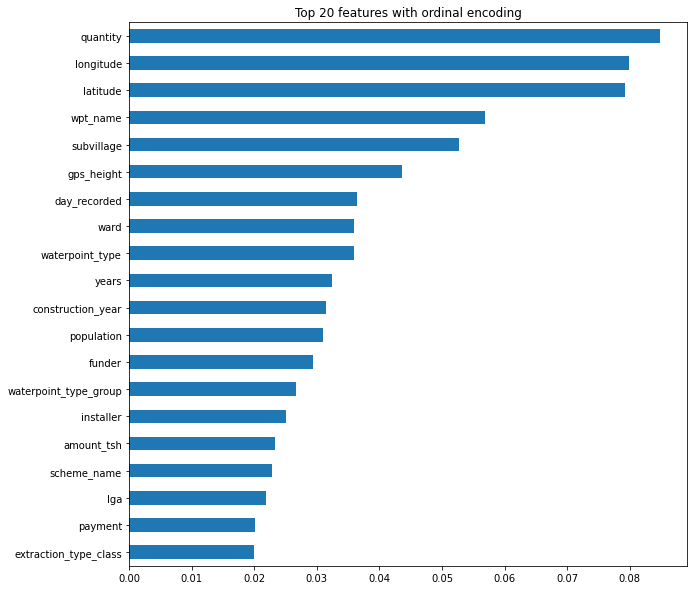

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot the top n feature importances
n = 20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features with ordinal encoding')
importances.sort_values()[-n:].plot.barh();


# Understand how categorical encodings affect trees differently compared to linear models

## Follow Along

### Categorical exploration, 1 feature at a time

Change `feature`, then re-run these cells!

In [0]:
feature = 'extraction_type_class'

In [30]:
X_train[feature].value_counts()

gravity         21448
handpump        13184
other            5193
submersible      4894
motorpump        2355
rope pump         353
wind-powered       93
Name: extraction_type_class, dtype: int64

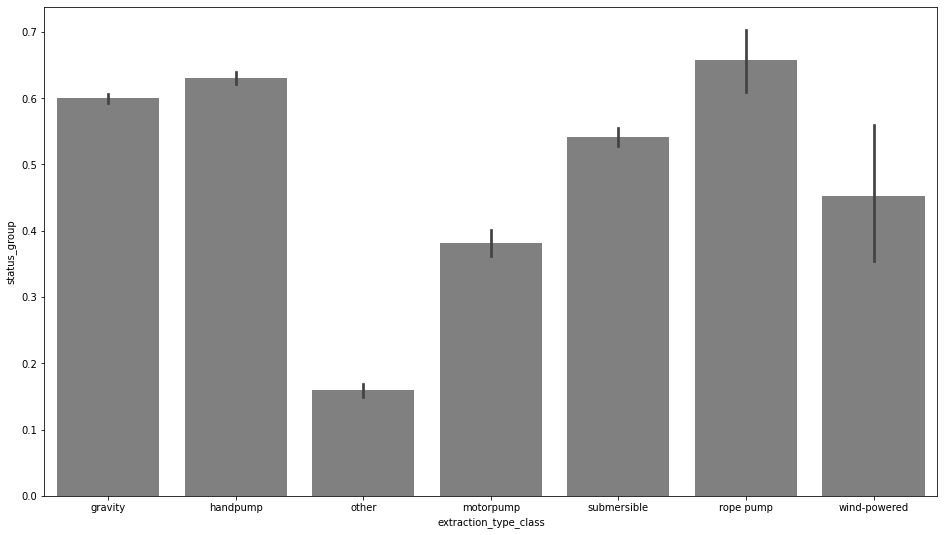

In [31]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[feature], 
    y=train['status_group']=='functional', 
    color='grey'
);

In [32]:
X_train[feature].head(20)

43360        gravity
7263         gravity
2486        handpump
313            other
52726      motorpump
8558         gravity
2559         gravity
54735      motorpump
25763       handpump
44540    submersible
28603          other
4372     submersible
30666        gravity
6431     submersible
57420          other
1373         gravity
2026         gravity
58977       handpump
41101        gravity
10019        gravity
Name: extraction_type_class, dtype: object

### [One Hot Encoding](https://contrib.scikit-learn.org/category_encoders/onehot.html)

> Onehot (or dummy) coding for categorical features, produces one feature per category, each binary.

Warning: May run slow, or run out of memory, with high cardinality categoricals!

In [33]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head(20)

7 columns


,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_submersible,extraction_type_class_rope pump,extraction_type_class_wind-powered
43360,1,0,0,0,0,0,0
7263,1,0,0,0,0,0,0
2486,0,1,0,0,0,0,0
313,0,0,1,0,0,0,0
52726,0,0,0,1,0,0,0
8558,1,0,0,0,0,0,0
2559,1,0,0,0,0,0,0
54735,0,0,0,1,0,0,0
25763,0,1,0,0,0,0,0
44540,0,0,0,0,1,0,0


#### One-Hot Encoding, Logistic Regression, Validation Accuracy

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.6202861952861953


#### One-Hot Encoding, Decision Tree, Validation Accuracy

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


#### One-Hot Encoding, Logistic Regression, Model Interpretation

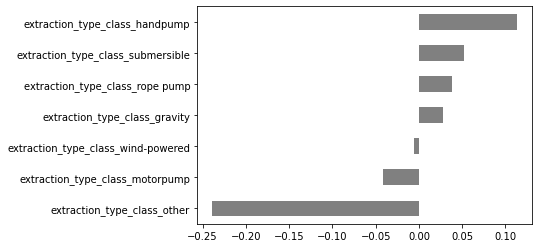

In [36]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

#### One-Hot Encoding, Decision Tree, Model Interpretation

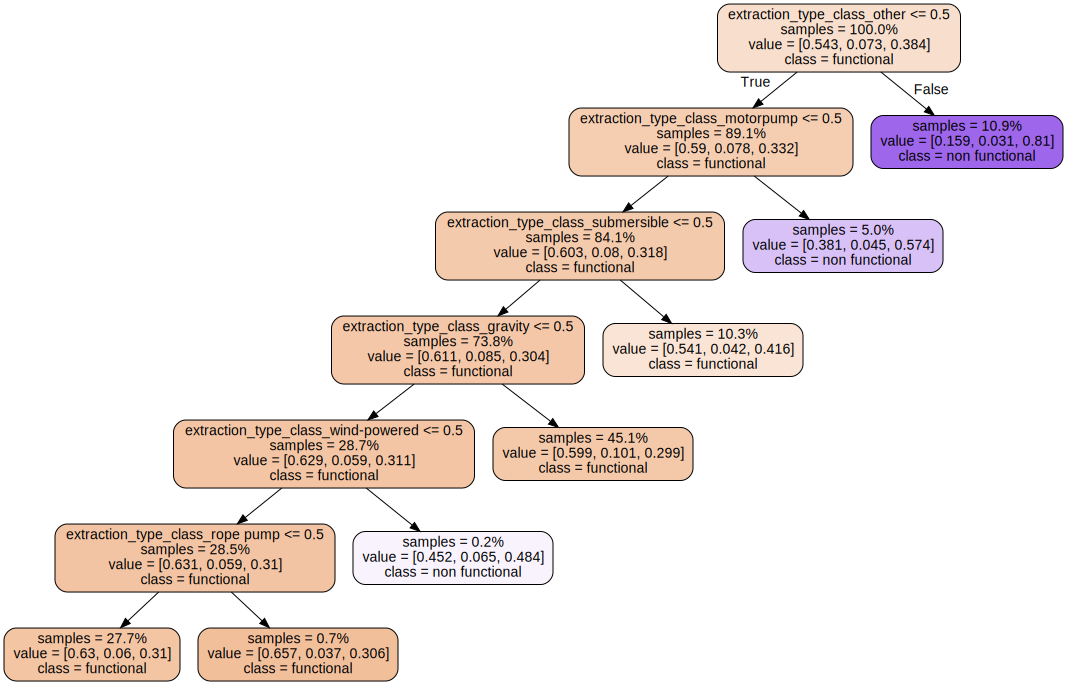

In [37]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=7, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

### [Ordinal Encoding](https://contrib.scikit-learn.org/category_encoders/ordinal.html)

> Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed in; in this case, we use the knowledge that there is some true order to the classes themselves. Otherwise, the classes are assumed to have no true order and integers are selected at random.

In [38]:
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(20)

1 column, 7 unique values


,extraction_type_class
43360,1
7263,1
2486,2
313,3
52726,4
8558,1
2559,1
54735,4
25763,2
44540,5


#### Ordinal Encoding, Logistic Regression, Validation Accuracy

In [39]:
lr = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.5417508417508418


#### Ordinal Encoding, Decision Tree, Validation Accuracy

In [40]:
dt = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


#### Ordinal Encoding, Logistic Regression, Model Interpretation

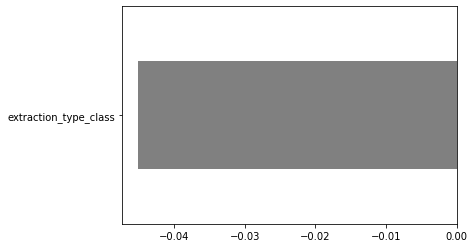

In [41]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

#### Ordinal Encoding, Decision Tree, Model Interpretation

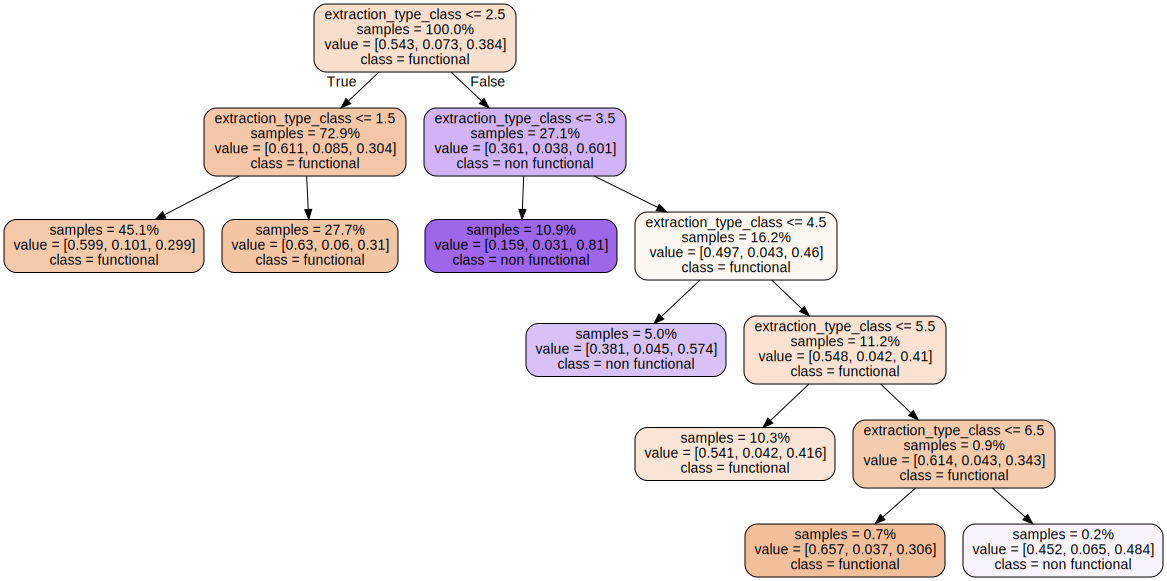

In [42]:
model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=5, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

# Understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

## Overview

### What's "random" about random forests?
1. Each tree trains on a random bootstrap sample of the data. (In scikit-learn, for `RandomForestRegressor` and `RandomForestClassifier`, the `bootstrap` parameter's default is `True`.) This type of ensembling is called Bagging. (Bootstrap AGGregatING.)
2. Each split considers a random subset of the features. (In scikit-learn, when the `max_features` parameter is not `None`.) 

For extra randomness, you can try ["extremely randomized trees"](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)!

>In extremely randomized trees (see [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

## Follow Along

### Example: [predicting golf putts](https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/)
(1 feature, non-linear, regression)

In [0]:
putts = pd.DataFrame(
    columns=['distance', 'tries', 'successes'], 
    data = [[2, 1443, 1346],
            [3, 694, 577],
            [4, 455, 337],
            [5, 353, 208],
            [6, 272, 149],
            [7, 256, 136],
            [8, 240, 111],
            [9, 217, 69],
            [10, 200, 67],
            [11, 237, 75],
            [12, 202, 52],
            [13, 192, 46],
            [14, 174, 54],
            [15, 167, 28],
            [16, 201, 27],
            [17, 195, 31],
            [18, 191, 33],
            [19, 147, 20],
            [20, 152, 24]]
)

putts['rate of success'] = putts['successes'] / putts['tries']
putts_X = putts[['distance']]
putts_y = putts['rate of success']

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

def putt_trees(max_depth=1, n_estimators=1):
    models = [DecisionTreeRegressor(max_depth=max_depth), 
              RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(putts_X, putts_y)
        ax = putts.plot('distance', 'rate of success', kind='scatter', title=name)
        ax.step(putts_X, model.predict(putts_X), where='mid')
        plt.show()
        
interact(putt_trees, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### Go back to Tanzania Waterpumps ...

#### Helper function to visualize predicted probabilities



In [0]:
import itertools
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features
    
    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    
    Returns
    -------
    y_pred_proba : numpy array, predicted probabilities for class_index
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    sns.heatmap(table, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()
    return y_pred_proba


### Compare Decision Tree, Random Forest, Logistic Regression

In [46]:
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'longitude'
feature2 = 'quantity'

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        pred_heatmap(model, X, [feature1, feature2], class_index=0, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

### Bagging

In [0]:
# Do-it-yourself Bagging Ensemble of Decision Trees (like a Random Forest)

# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders

feature1 = 'longitude'
feature2 = 'latitude'

def waterpumps_bagging(max_depth=1, n_estimators=1):
    predicteds = []
    for i in range(n_estimators):
        title = f'Tree {i+1}'
        bootstrap_sample = train.sample(n=len(train), replace=True)
        X, y = get_X_y(bootstrap_sample, feature1, feature2, target='status_group')
        tree = DecisionTreeClassifier(max_depth=max_depth)
        tree.fit(X, y)
        predicted = pred_heatmap(tree, X, [feature1, feature2], class_index=0, title=title)
        predicteds.append(predicted)
    
    ensembled = np.vstack(predicteds).mean(axis=0)
    title = f'Ensemble of {n_estimators} trees, with max_depth={max_depth}'
    sns.heatmap(ensembled.reshape(100, 100).T, vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.show()
        
interact(waterpumps_bagging, max_depth=(1,6,1), n_estimators=(2,5,1));

# Review

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.
